# Proyecto Final

### Equipo: CodeMonkeys
### Materia: Inteligencia Artificial

### Integrantes:

- Díaz Villegas Erick
- Hernandez García Carlos Zahid
- Ordaz Rebollo Ximena


## Lectura y preprocesado de datos general
- Discretizar salida (G3)
- Eliminar variables dependientes (G1, G2, Medu, Walc)
- Separacion del dataset

In [2]:
#Importacion de librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import metrics
import networkx as nx
import matplotlib.pyplot as plt

### Funciones

In [3]:
#Funciones

#Discretizar salida
def fnDisc(x):
    if(x>=10):
        return 1
    else:
        return 0
    
#Funcion de probabilidad Gaussiana    
def fnGaussiana(x,mu,s2):
    A = 1/(np.sqrt(2*np.pi*s2))
    B = -0.5*((x-mu)**2/s2)
    fg = A*np.exp(B) # vectorial
    return fg

#Funcion de probabilidad Gumbel
def fnGumbel(x, mu, beta):
    z = (x - mu) / beta
    fgum = (1 / beta) * np.exp(-(z + np.exp(-z)))
    return fgum

#Funcion de probabilidad Exponencial
def fnExponencial(x, lamda):
    fe = lamda * np.exp(-lamda * x)
    return fe

#Generar un grafo de dependencias a partir de un valor critico
def fnDepGraph(data, axFn, crit):
    datos = data.to_numpy()
    mCorr = np.corrcoef(datos, rowvar=False).round(decimals=1)
    colnames = data.columns.values

    dependencias = np.abs(mCorr) >= crit

    grafo = nx.Graph()

    #Nodos y aristas
    for i in range(len(mCorr)):
        for j in range(len(mCorr)):
            if (i != j and dependencias[i, j]):
                grafo.add_edge(colnames[i], colnames[j], weight=mCorr[i,j])

    pos = nx.circular_layout(grafo)

    #Nodos
    nx.draw_networkx_nodes(grafo, pos, ax=axFn, node_size=1000)

    #Edges
    nx.draw_networkx_edges(grafo, pos, ax=axFn, edgelist=grafo.edges)

    #Node labels
    nx.draw_networkx_labels(grafo, pos, ax=axFn, font_size=9)

    #Edge labels
    edgeLabels = nx.get_edge_attributes(grafo,"weight")
    nx.draw_networkx_edge_labels(grafo, pos, ax=axFn, edge_labels=edgeLabels)

### Funciones predicciones

In [4]:
#Funciones predicciones

#Prediccion del Naive Bayes Gaussiano
def fnPredictNBG(test_data,estadisticos,probPriori):
    nvariables = test_data.shape[1]-1
    predicciones = np.zeros(len(test_data),dtype=int)
    probPosteriori = np.zeros(len(probPriori))

    for k in range(0,len(test_data)): # filas
        for i in range(0,len(probPriori)): # clases
            probPosteriori[i] = np.log(probPriori[i]) #Obtener la priori de la clase
            for j in range(0,nvariables): # variables/columnas
                x = test_data.iloc[k,j]
                mu = estadisticos[j,2*i]
                s2 = estadisticos[j,2*i+1]
                probPosteriori[i] += np.log(fnGaussiana(x,mu,s2))
        predicciones[k] = np.argmax(probPosteriori)

    return predicciones

#Prediccion del Naive Bayes Multinomial
def fnPredictNBM(data, priori, condicional):

    colNames = data.columns.values
    colNames = colNames[:-1]

    predicciones = []

    for value in data.values: #value es el vector de informacion (filas)
        logReprobado = np.log(priori[0])
        logAprobado = np.log(priori[1])

        for x in range(0,len(colNames)): #Columnas
            logReprobado += np.log(condicional.at[colNames[x],0][value[x]-1]) #-1 ya que los indices son del 0 al 4 y los valores del 1 al 5
            logAprobado += np.log(condicional.at[colNames[x],1][value[x]-1]) #igual que arriba

        if logReprobado > logAprobado:
            predicciones.append(0)  
        else:
            predicciones.append(1)  
    
    return predicciones

#Prediccion del Naive Bayes Mixto
def fnPredictNBMix(test_data, estadisticos_mixto, probPriori):
    nvariables = test_data.shape[1] - 1
    predicciones = np.zeros(len(test_data), dtype=int)
    prob_posteriori = np.zeros(len(probPriori))
    
    for k in range(len(test_data)):  # Filas
        for i in range(len(probPriori)):  #Clases
            prob_posteriori[i] = np.log(probPriori[i])
            for j in range(nvariables):  # Columnas (o variables)
                x = test_data.iloc[k, j]  # Valor
                col_name = test_data.columns[j]
                
                # Funcion de densidad segun el analisis anterior
                if col_name in ['age', 'Fedu', 'freetime', 'goout']:  #Gaussiana
                    media = estadisticos_mixto[j, 3 * i]
                    var = estadisticos_mixto[j, 3 * i + 2]  # Nota: la desviación estándar cuadrada es la varianza
                    
                    prob_posteriori[i] += np.log(fnGaussiana(x, media, var))

                elif col_name in ['studytime', 'famrel', 'health']:  #Gumbel
                    moda = estadisticos_mixto[j, 3 * i + 1]
                    var = estadisticos_mixto[j, (3 * i + 2)]
                    std = np.sqrt(var)
                    beta = std*0.78

                    prob_posteriori[i] += np.log(fnGumbel(x, moda, beta))
                    
                else:  # Exponencial
                    media = estadisticos_mixto[j, 3 * i]
                    lamda = 1/media

                    prob_posteriori[i] += np.log(fnExponencial(x, lamda))
        
        predicciones[k] = np.argmax(prob_posteriori)
    
    return predicciones

### Lectura de datos

In [5]:
# Importar data
data = pd.read_csv("student-mat.csv", sep=';')

#Variables utilizadas en el analisis
data = data.loc[:,['age','Medu','Fedu','traveltime','studytime','failures','famrel','freetime','goout','Dalc','Walc','health','absences','G1','G2','G3']]
colNames = data.columns.values

### Grafo de dependencias

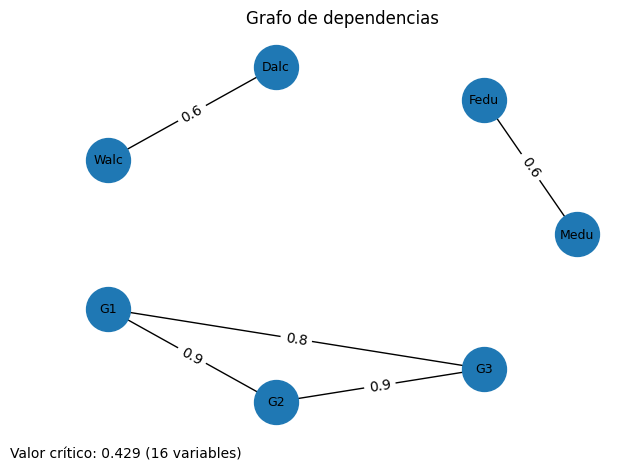

In [6]:
# Realizar matriz de correlacion y grafo de dependencias del trabajo anterior
mCorr = data.corr().round(2)

#Grafo con las dependencias más significativas
fig, ax = plt.subplots()
fnDepGraph(data=data, axFn=ax, crit=0.429) #Valor de spearman
ax.set_title("Grafo de dependencias")
ax.text(-1.3,-1.3,"Valor crítico: 0.429 (16 variables)")
plt.axis("off")
plt.tight_layout()
plt.show()


### Preprocesado 

In [7]:
#Eliminar las variables dependientes
data = data.loc[:, ~data.columns.isin(['G1', 'G2', 'Medu', 'Walc'])]

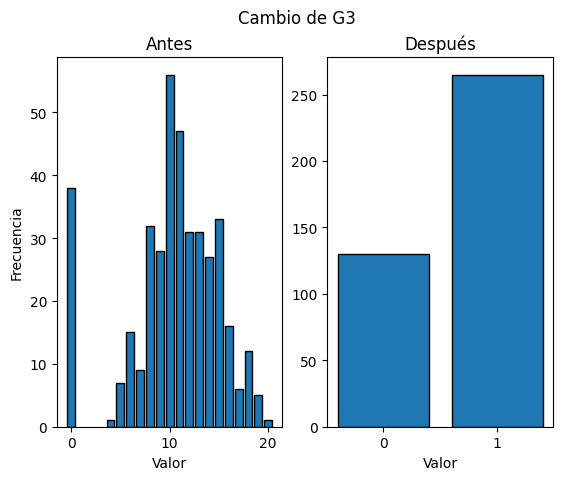

In [8]:
#Discretizacion de salida G3
G3Col = data['G3'].apply(fnDisc)

# Gráfico de barras G3 (Antes vs Despues)
fig, ax = plt.subplots(1,2)

#Antes
frecuencias = data['G3'].value_counts()
ax[0].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[0].set_xticks(np.linspace(min(frecuencias.index), max(frecuencias.index), num=3))
ax[0].set_xlabel('Valor')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Antes')

#Despues
frecuencias = G3Col.value_counts()
ax[1].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[1].set_xticks(frecuencias.index)
ax[1].set_xlabel('Valor')
ax[1].set_title('Después')

fig.suptitle('Cambio de G3')
plt.show()

data['G3'] = G3Col

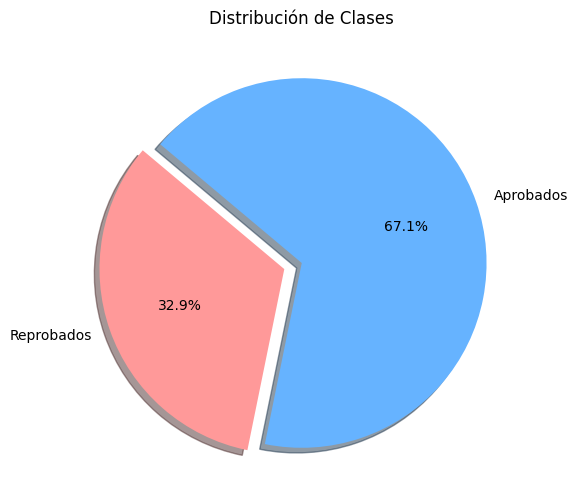

In [9]:
Reprobados = len(data[data['G3'] == 0])
Aprobados = len(data[data['G3'] == 1])

# Datos para el gráfico de pastel
labels = ['Reprobados', 'Aprobados']
sizes = [Reprobados, Aprobados]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode la primera rebanada (Clase 0)

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribución de Clases')
plt.show()

In [10]:
#Separacion del dataset (80-20)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

## Naive Bayes Gaussiano

### Aprendizaje

In [11]:
#Aprender las prioris
frecEnf = np.sum(train_data.iloc[:,-1] == 1)
probPriori = np.array([train_data.shape[0]-frecEnf, frecEnf])/train_data.shape[0]

In [12]:
# Aprender los Likelihood (estadisticos)
nc = data.iloc[:,-1].nunique() # <--- Automatico
nvariables = train_data.shape[1]-1
estadisticosNBG = np.zeros((nvariables,nc*2)) # reservar el espacio en memoria

# obtener los estadísticos
for i in range(0,nc): # clases
    for j in range(0,nvariables): # variables
        train_variableK = train_data[train_data.iloc[:,-1]==i].iloc[:,j]
        estadisticosNBG[j,0+2*i:2+2*i] = np.array([np.mean(train_variableK), 
                                        np.var(train_variableK)]).round(2)

### Prediccion

In [13]:
NBGprediccion = fnPredictNBG(test_data,estadisticosNBG,probPriori)
real = test_data.iloc[:,-1]

#Matriz de confusion
mConfNBG = metrics.confusion_matrix(real,NBGprediccion)
print(mConfNBG)

NBGrendimiento = sum(NBGprediccion == real) / test_data.shape[0]
print(str(round(NBGrendimiento*100,2))+'%')

[[14 10]
 [ 5 50]]
81.01%


## Naive Bayes Multinomial

### Preprocesado para multinomial
- Discretizacion de age y absences
- Estandarizacion de valores (todos del 1 al 5) para facilitar acceso mediante indices

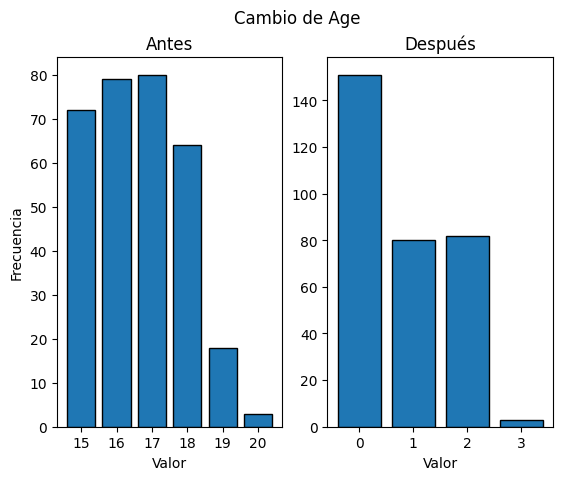

In [14]:
#Nuevos DF para almacenar la info con los discretizados
train_data_mult = train_data.copy()
test_data_mult = test_data.copy()

################

#Discretizar age
ageDiscretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
ageDiscretizer.fit(data[['age']])

trainAgeDisc = ageDiscretizer.transform(train_data[['age']])
testAgeDisc = ageDiscretizer.transform(test_data[['age']])

# Convertir los resultados a DataFrames
trainAgeDisc = pd.DataFrame(trainAgeDisc, columns=['age'])
testAgeDisc = pd.DataFrame(testAgeDisc, columns=['age'])

# Si no se copian los indices entonces creara nulls al pasar los datos de la columna discretizada a la del DF
trainAgeDisc.index = train_data_mult.index
testAgeDisc.index = test_data_mult.index

#Convertir a enteros
train_data_mult['age'] = trainAgeDisc.astype(int)
test_data_mult['age'] = testAgeDisc.astype(int)

# Gráfico de barras age (Antes vs Despues)
fig, ax = plt.subplots(1,2)

#Antes
frecuencias = train_data['age'].value_counts()
ax[0].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[0].set_xticks(np.linspace(min(frecuencias.index), max(frecuencias.index), num=6))
ax[0].set_xticklabels(np.linspace(min(frecuencias.index), max(frecuencias.index), num=6, dtype=int))
ax[0].set_xlabel('Valor')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Antes')

#Despues
frecuencias = trainAgeDisc['age'].value_counts()
ax[1].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[1].set_xticks(frecuencias.index)
ax[1].set_xlabel('Valor')
ax[1].set_title('Después')

fig.suptitle('Cambio de Age')
plt.show()

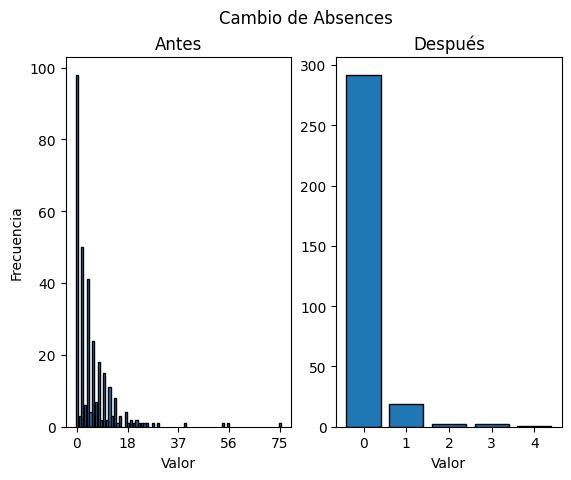

In [15]:
#Discretizar absences
absDiscretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
absDiscretizer.fit(data[['absences']])

trainAbsDisc = absDiscretizer.transform(train_data[['absences']])
testAbsDisc = absDiscretizer.transform(test_data[['absences']])

# Convertir los resultados a DataFrames
trainAbsDisc = pd.DataFrame(trainAbsDisc, columns=['absences'])
testAbsDisc = pd.DataFrame(testAbsDisc, columns=['absences'])

# Si no se copian los indices entonces creara nulls al pasar los datos de la columna discretizada a la del DF
trainAbsDisc.index = train_data_mult.index
testAbsDisc.index = test_data_mult.index

#Convertir a enteros
train_data_mult['absences'] = trainAbsDisc.astype(int)
test_data_mult['absences'] = testAbsDisc.astype(int)

# Gráfico de barras absences (Antes vs Despues)
fig, ax = plt.subplots(1,2)

#Antes
frecuencias = train_data['absences'].value_counts()
ax[0].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[0].set_xticks(np.linspace(min(frecuencias.index), max(frecuencias.index), num=5))
ax[0].set_xticklabels(np.linspace(min(frecuencias.index), max(frecuencias.index), num=5, dtype=int))

ax[0].set_xlabel('Valor')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Antes')

#Despues
frecuencias = trainAbsDisc['absences'].value_counts()
ax[1].bar(frecuencias.index, frecuencias.values, edgecolor='black')
ax[1].set_xticks(frecuencias.index)
ax[1].set_xlabel('Valor')
ax[1].set_title('Después')

fig.suptitle('Cambio de Absences')
plt.show()

In [16]:
#Aumentar las que van de 0-4 a 1-5 (age, fedu, failures, absences)
#Esto fue para facilitar el acceso a indices estadisticos

train_data_mult['age'] += 1
test_data_mult['age'] += 1

train_data_mult['Fedu'] += 1
test_data_mult['Fedu'] += 1

train_data_mult['failures'] += 1
test_data_mult['failures'] += 1

train_data_mult['absences'] += 1
test_data_mult['absences'] += 1

### Aprendizaje

In [17]:
#Las prob a priori son las mismas 
probPrioriNBM = probPriori

#Calcular las probs condicionales

#Reservar el espacio arreglo de 5 posibles valores en una matriz de (numero de variables)(numero de clases) 
colNamesNBM = data.columns.values
colNamesNBM = colNamesNBM[:-1]

espacio = [[np.zeros(5) for _ in range(nc)] for _ in range(len(colNamesNBM)) ]

probCondNBM = pd.DataFrame(espacio, columns=data.iloc[:,-1].unique())
probCondNBM.index = colNamesNBM

In [18]:
#Obtener las frecuencias de cada variable
for clase in probCondNBM.columns.values: #clases (0 y 1)
    subset = train_data_mult[train_data_mult.iloc[:,-1] == clase] #data solo con la salida de una clase en especifico
    for col in colNamesNBM: #Columna
        for value in range(1,6): #Valores (1-5)
            countValue = subset[col].value_counts().get(value, 0) #Frecuencia
            countValue += 1 #para evitar 0's
            totalClass = len(subset) #total 
            probCondNBM.at[col, clase][value-1] = round((countValue / totalClass),3) #probabilidad


### Prediccion

In [19]:
NBMprediccion = fnPredictNBM(test_data_mult, probPrioriNBM, probCondNBM)
NBMprediccion = np.asarray(NBMprediccion)

#Matriz de confusion
mConfNBM = metrics.confusion_matrix(real,NBMprediccion)
print(mConfNBM)

NBMrendimiento = sum(NBMprediccion == real) / test_data.shape[0]
print(str(round(NBMrendimiento*100,2))+'%')

[[14 10]
 [14 41]]
69.62%


## Naive Bayes Mixto
- Funciones de probabilidad segun el histograma del analisis anterior

### Aprendizaje

In [20]:
# Aprender los Likelihood (estadisticos)
nc = data.iloc[:,-1].nunique() # <--- Automatico
nvariables = train_data.shape[1]-1
estadisticosNBMix = np.zeros((nvariables,nc*3)) # reservar el espacio en memoria
# obtener los estadísticos
for i in range(0,nc): # clases
    for j in range(0,nvariables): # variables
        train_variableK = train_data[train_data.iloc[:,-1]==i].iloc[:,j]

        #A partir de estos 3 se puede calcular lo necesario para las funciones de probabilidad
        media = np.mean(train_variableK) #Media
        moda = train_variableK.mode().max()  # Moda
        var = train_variableK.var() #Varianza

        estadisticosNBMix[j,0+3*i:3+3*i] = np.array([media, 
                                        moda,
                                        var])
        
        #Posiciones posibles de:
        #Media:0, 3
        #Moda:1, 4
        #Varianza:2, 5

### Prediccion

In [21]:
# Realizar predicciones
NBMixprediccion = fnPredictNBMix(test_data, estadisticosNBMix, probPriori)

#Matriz de confusion
mConfNBMix = metrics.confusion_matrix(real,NBMixprediccion)
print(mConfNBMix)

#Rendimiento
NBMixrendimiento = sum(NBMixprediccion == real) / test_data.shape[0]
print(str(round(NBMixrendimiento*100,2))+'%')

[[13 11]
 [ 4 51]]
81.01%


## Implementacion de ensamble de Naive Bayes

In [22]:
NBEprediccion = np.vstack((NBGprediccion, NBMprediccion, NBMixprediccion)).T
NBEprediccion = pd.DataFrame(NBEprediccion, columns=['Gaussiano','Multinomial','Mixto'])
modaPredicciones = NBEprediccion.mode(axis=1)[0] #si no se pone el [0] se pasan como arreglos
modaPredicciones = modaPredicciones.to_numpy() #para poder hacer la matriz 

In [23]:
#Matriz de confusion
mConfNBE = metrics.confusion_matrix(real,modaPredicciones)
print(mConfNBE)

#Rendimiento
NBErendimiento = sum(modaPredicciones == real) / test_data.shape[0]
print(str(round(NBErendimiento*100,2))+'%')

[[15  9]
 [ 5 50]]
82.28%


### Resultados por modelo

In [24]:
print("Naive Bayes Gaussiano (NBG):")
print(str(round(NBGrendimiento*100,2))+'% \n')

print("Naive Bayes Multinomial (NBM):")
print(str(round(NBMrendimiento*100,2))+'% \n')

print("Naive Bayes Mixto (NBMix):")
print(str(round(NBMixrendimiento*100,2))+'% \n')

print("Ensamble de Naive Bayes (NBE):")
print(str(round(NBErendimiento*100,2))+'% \n')

Naive Bayes Gaussiano (NBG):
81.01% 

Naive Bayes Multinomial (NBM):
69.62% 

Naive Bayes Mixto (NBMix):
81.01% 

Ensamble de Naive Bayes (NBE):
82.28% 



In [26]:
print(estadisticosNBMix)

[[ 16.98113208  17.           1.59964061  16.46666667  16.
    1.44625199]
 [  2.40566038   3.           1.13863432   2.62380952   2.
    1.19273183]
 [  1.5          1.           0.51904762   1.36666667   1.
    0.43429027]
 [  1.91509434   2.           0.57367475   2.1          2.
    0.76985646]
 [  0.59433962   0.           0.8148248    0.15714286   0.
    0.23834586]
 [  3.88679245   4.           0.84420485   3.96666667   4.
    0.86491228]
 [  3.16981132   3.           0.96136568   3.24761905   3.
    1.00059239]
 [  3.36792453   3.           1.32048518   3.02857143   3.
    1.12836637]
 [  1.51886792   1.           0.6901168    1.47142857   1.
    0.81496924]
 [  3.66981132   5.           1.72803235   3.50952381   5.
    2.07885623]
 [  6.35849057   0.         114.80359389   5.14761905   0.
   44.28910914]]
